### Обзор данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import warnings
from plotly import graph_objects as go
import plotly.express as px
import math as mth
import os
from scipy import stats as st
import re
import plotly.figure_factory as ff
import itertools
!pip install -U kaleido

In [3]:
# просмотр общей информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [4]:
# выводим первые 5 строк датасета 
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [5]:
# отобразим статистическую сводку по столбцам с числовыми значениями
data.describe().round(1)

,date,order_id,quantity,price
count,7.474000e+03,7474.0,7474.0,7474.0
mean,2.018913e+09,49449.9,2.4,478.7
std,4.278878e+05,32679.6,14.5,901.6
min,2.018100e+09,12624.0,1.0,9.0
25%,2.019022e+09,14833.0,1.0,97.0
50%,2.019051e+09,68768.0,1.0,135.0
75%,2.019063e+09,71257.8,1.0,439.0
max,2.020013e+09,112789.0,1000.0,14917.0


In [6]:
# отобразим статистическую сводку по столбцам с типом данных object
display(data.describe(include = ['object']).T)

,count,unique,top,freq
customer_id,7474,2451,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,888
product,7474,2343,Рассада Кабачка сорт Зебра кассета 6 шт E6,79


#### Вывод
Исходный датафрейм состоит из 7474 строк, 6 столбцов. Тип данных - float64(1), int64(3), object(2). Наименование столбцов оформлено в соответствии со стилем написания Snake case (змеиный регистр), поэтому не требует переименования. Столбец date имеет ошибочный тип int вместо datetime. 

Статистическая сводка по столбцам с числовыми значениями свидетельствует о наличии выбросов в данных quantity, price. В связи с тем, что максимальное значение столбца price (товар ценой 14917 рублей) в сравнении со средним и медианным значениями велико, но вероятно, предлагается его сохранить для дальнейшего анализа. Значение "1000 товаров в заказе" в столбце quantity будет дополнительно проанализировано на этапе предобработки данных.

Самый активный покупатель с идентификатором 1d6c8c1f-a799-4418-9af2-1ded47d7a85c встречается в датасете 888 раз, самый покупаемый товар "Рассада Кабачка сорт Зебра кассета 6 шт." приобретен 79 раз.

### Предобработка данных

In [7]:
# меняем тип данных в столбце data['date']
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [8]:
# приводим столбец к нижнему регистру
data['product'] = data['product'].str.lower()

In [9]:
# анализируем количество полных дубликатов
data.duplicated().sum()

0

In [10]:
# анализируем количество дубликатов по сумме ключевых параметров
data.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity', 'price']).sum()

1864

In [11]:
# удаляем дубликаты по подмножеству
data = data.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'], keep='last')

In [12]:
# анализируем количество дубликатов по сумме ключевых параметров
data.duplicated(subset=['order_id', 'product', 'quantity']).sum()

36

In [13]:
# удаляем дубликаты по подмножеству
data = data.drop_duplicates(subset=['order_id', 'product', 'quantity'], keep='last')

In [14]:
# считаем неявные дубликаты по условию 1 заказ =  1 покупатель
data.groupby('order_id').agg({'customer_id': 'nunique'}).query('customer_id > 1').count()

customer_id    1
dtype: int64

In [15]:
# считаем неявные дубликаты по условию 1 заказ =  1 дата
data.groupby('order_id').agg({'date': 'nunique'}).query('date > 1').count()

date    25
dtype: int64

In [16]:
# удаляем неявные дубликаты по условию 1 заказ =  1 покупатель
duplicate_orders = data.groupby('order_id').agg({'customer_id': 'nunique'}).query('customer_id > 1')
data = data.drop(data[data['order_id'].isin(duplicate_orders.index)].index)

In [17]:
# удаляем неявные дубликаты по условию 1 заказ =  1 дата
duplicate_dates = data.groupby('order_id').agg({'date': 'nunique'}).query('date > 1')
data = data.drop(data[data['order_id'].isin(duplicate_dates.index)].index)

In [18]:
# проверяем наличие пропущенных значений в датасете
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [19]:
# считаем частотность количества товара в заказе
print(data['quantity'].value_counts())
print(len(data['quantity'].unique()))

1       4342
2        489
3        138
4        101
10        70
5         67
6         41
15        23
7         20
20        16
25        15
30        15
8         13
12        12
50         8
9          6
13         5
11         5
100        4
16         4
24         3
150        3
40         3
27         2
64         2
60         2
14         2
31         1
334        1
23         1
170        1
70         1
43         1
45         1
26         1
22         1
18         1
65         1
57         1
37         1
29         1
17         1
1000       1
300        1
200        1
140        1
96         1
80         1
59         1
Name: quantity, dtype: int64
49


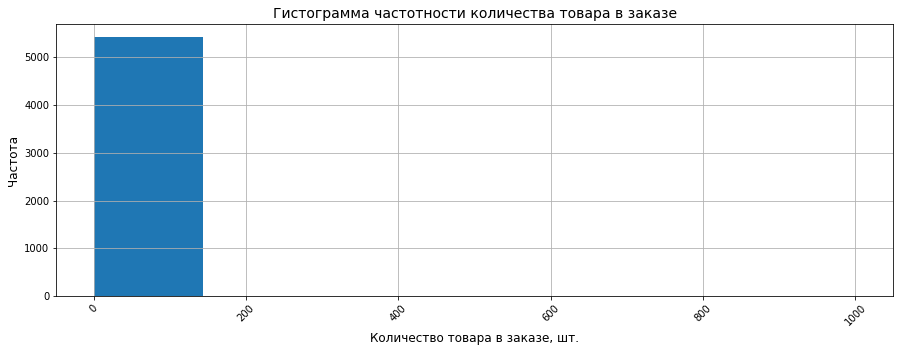

In [20]:
# строим график распределения частотности количества товара в заказе
data['quantity'].hist(bins=7, figsize=(15, 5))
plt.title('Гистограмма частотности количества товара в заказе', fontsize=14)
plt.ylabel('Частота', fontsize=12)
plt.tick_params(labelsize=10)
plt.xlabel('Количество товара в заказе, шт.', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [21]:
# находим заказ с 1000 товаров
data.query('quantity == 1000')

,date,customer_id,order_id,product,quantity,price
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0


In [22]:
# удаляем заказ с 1000 товаров
data = data.query('order_id != 71743')

In [23]:
# создаем столбец с выручкой от продажи товаров
data['revenue'] = data['quantity']*data['price']

In [24]:
# проверяем результат предобработки и выводим первые 5 строк датасета
data.head()

,date,customer_id,order_id,product,quantity,price,revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0


In [25]:
# проверяем результат предобработки и выводим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5432 entries, 0 to 7473
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5432 non-null   datetime64[ns]
 1   customer_id  5432 non-null   object        
 2   order_id     5432 non-null   int64         
 3   product      5432 non-null   object        
 4   quantity     5432 non-null   int64         
 5   price        5432 non-null   float64       
 6   revenue      5432 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 339.5+ KB


#### Вывод
1.	Столбец date  приведен к типу данных datetime;
2.  Предполагая вариативность написания наименований товаров, столбец product приведен к нижнему регистру;
3.	Полные дубликаты и пропущенные значения в датасете отсутствуют;
4.  Анализируемый датасет не содержит информацию о событиях покупки (просмотр товара, добавление в корзину и пр.), в связи с чем видится возможным ошибочная выгрузка идентичной информации с разными датами, поэтому проверены и удалены дубликаты по ключевым параметрам в количестве 1900 строк, оставлены последние записи, подразумевающие совершение покупки.
5.  Удалена 141 строка в результате обработки неявных дубликатов по условиям 1 заказ = 1 покупатель и 1 заказ = 1 дата.
6.  В результате анализа параметра "количество товара в заказе" исключен из датасета заказ в 1000 товаров как аномальное значение.

Таким образом, датафрейм после предобработки состоит из 5432 строк, 7 столбцов. Тип данных - datetime64(1), float64(2), int64(2), object(2).

### Исследовательский анализ данных

In [26]:
# определяем наблюдаемый период
print('Наблюдаемый период: с', data['date'].min().date(), 'по' , data['date'].max().date())

Наблюдаемый период: с 2018-10-01 по 2020-01-31


In [27]:
# определяем количество уникальных покупателей в датасете
print('Количество уникальных покупателей в датасете составляет', data['customer_id'].nunique(), 'человек.')

# определяем количество уникальных заказов в датасете
print('Количество уникальных заказов в датасете составляет', data['order_id'].nunique(), 'ед.')

# определяем количество уникальных товаров в датасете
print('Количество уникальных товаров в датасете составляет', data['product'].nunique(), 'шт.')

Количество уникальных покупателей в датасете составляет 2408 человек.
Количество уникальных заказов в датасете составляет 3495 ед.
Количество уникальных товаров в датасете составляет 2307 шт.


In [28]:
# группируем датасет по месяцам наблюдаемого периода
grouped_by_date = data.groupby(data['date'].astype('datetime64[M]'))\
.agg({'customer_id':'nunique', 'order_id':'nunique', 'quantity':'sum', 'price':'mean', 'revenue':'sum'}).reset_index()
grouped_by_date.round(1)

,date,customer_id,order_id,quantity,price,revenue
0,2018-10-01,176,235,1495,555.7,327137.0
1,2018-11-01,178,204,1240,540.2,359772.0
2,2018-12-01,226,276,963,836.3,341770.0
3,2019-01-01,149,165,630,693.2,230008.0
4,2019-02-01,242,283,928,626.6,297451.0
5,2019-03-01,230,245,1016,500.8,252945.0
6,2019-04-01,234,262,1438,330.3,313889.0
7,2019-05-01,163,177,1495,232.9,226086.0
8,2019-06-01,151,161,945,415.7,230191.0
9,2019-07-01,184,195,527,641.0,224426.0


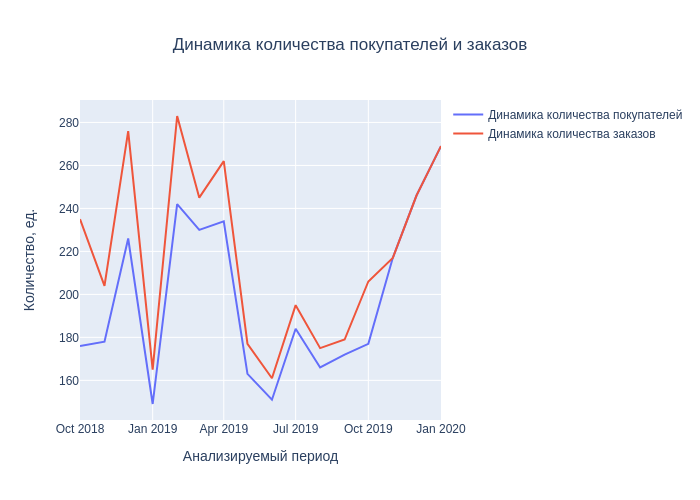

In [29]:
# Создаем фигуру и оси
fig = go.Figure()
 
# Добавляем первый график
fig.add_trace(go.Scatter(x=grouped_by_date['date'], y=grouped_by_date['customer_id'], mode='lines',\
                         name='Динамика количества покупателей'))
 
# Добавляем второй график
fig.add_trace(go.Scatter(x=grouped_by_date['date'], y=grouped_by_date['order_id'], mode='lines',\
                         name='Динамика количества заказов'))
 
fig.update_layout(
    title={
        'text': 'Динамика количества покупателей и заказов',
        'xanchor': 'center',
        'x':0.5
    },
    yaxis_title='Количество, ед.',
    xaxis_title='Анализируемый период')
# Отображаем график
fig.show('png')

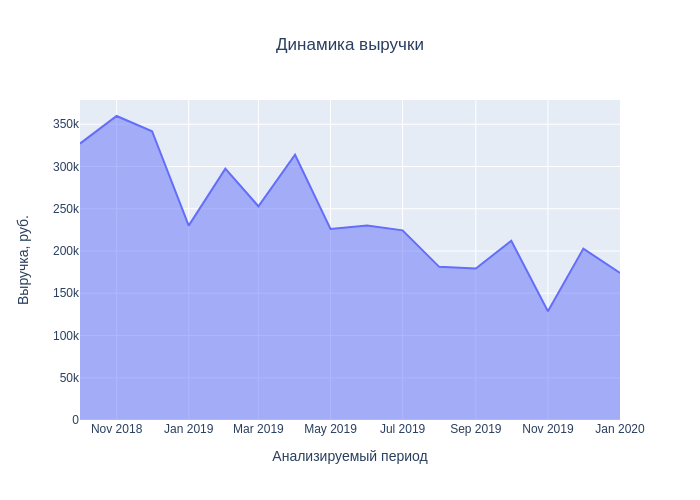

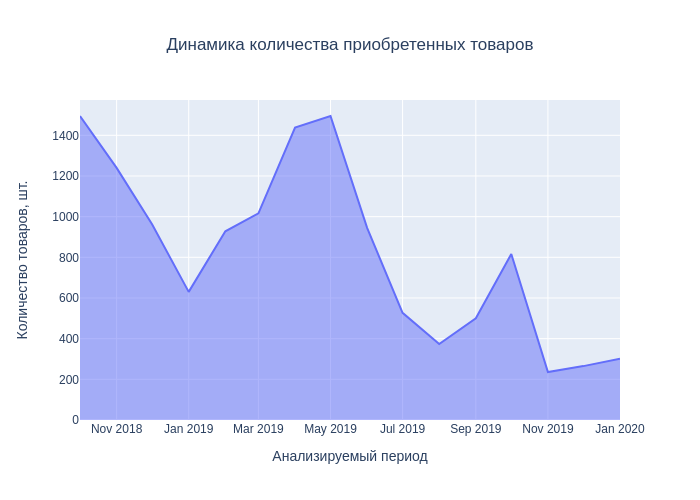

In [30]:
# строим графики динамики показателей за анализируемый период

fig = go.Figure(data=go.Scatter(x=grouped_by_date['date'], 
                                y=grouped_by_date['revenue'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': 'Динамика выручки',
        'xanchor': 'center',
        'x':0.5
    },
    yaxis_title='Выручка, руб.',
    xaxis_title='Анализируемый период')
fig.show('png')

fig = go.Figure(data=go.Scatter(x=grouped_by_date['date'], 
                                y=grouped_by_date['quantity'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': 'Динамика количества приобретенных товаров',
        'xanchor': 'center',
        'x':0.5
    },
    yaxis_title='Количество товаров, шт.',
    xaxis_title='Анализируемый период')
fig.show('png')

Сводная таблица и графики суммарных показателей анализируемого периода свидетельствуют о том, что: 
- количество заказов было выше количества покупателей до ноября 2019 г., с этого периода количество заказов совпадает с количеством покупателей;
- количество покупателей к концу наблюдаемого периода растет;
- при росте числа покупателей выручка и количество приобретенных товаров снижается;
- в целом графики не демонстируют сезонных колебаний.

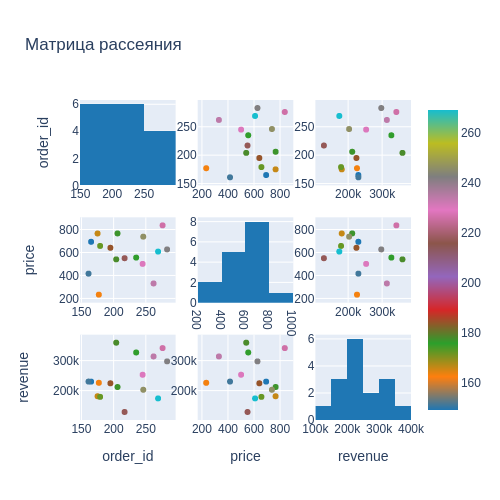

In [31]:
# строим матрицу рассеяния по основным показателям
figure = ff.create_scatterplotmatrix(
    grouped_by_date[['customer_id', 'order_id', 'price', 'revenue']],
    diag='histogram',
    index='customer_id', title = 'Матрица рассеяния')
figure.show('png')

Матрица рассеяния демонстрирует отсутствие выраженной корреляции показателей выручки, количества заказов и средней стоимости товара в разрезе количества покупателей.

In [32]:
# сгруппируем датасет по покупателям
grouped_by_customer = data.groupby(['customer_id'])\
.agg({'order_id':'nunique', 'quantity':['sum', 'mean'], 'price':'mean', 'revenue':['sum', 'mean']}).reset_index()
grouped_by_customer.columns = ['customer_id', 'orders', 'total_quantity', 'avg_quantity', \
                               'avg_price', 'total_revenue', 'avg_revenue']
grouped_by_customer.head(10)

,customer_id,orders,total_quantity,avg_quantity,avg_price,total_revenue,avg_revenue
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4,1.0,138.75,555.0,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,1.0,442.00,442.0,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2,2.0,457.00,914.0,914.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1.0,1649.00,1649.0,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2,2.0,1162.00,2324.0,2324.00
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,1,12,12.0,128.00,1536.0,1536.00
6,005ba170-45e8-42de-93f7-192481ae2659,2,3,1.5,2264.00,7857.0,3928.50
7,00bd74b1-2792-47db-a2f1-680a09ac5026,1,1,1.0,937.00,937.0,937.00
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,2,2,1.0,160.50,321.0,160.50
9,00c95d20-923e-4b45-88fc-53b12931d462,2,2,1.0,572.75,1145.5,572.75


In [33]:
# выводим основные показатели в разрезе на одного покупателя
print('Среднее количество заказов на одного покупателя: {:.1f} ед.'.format(grouped_by_customer['orders'].mean()))
print('Средняя выручка на одного покупателя: {:.1f} рублей.'.format(grouped_by_customer['total_revenue'].mean()))
print('Средняя сумма заказа по покупателям: {:.1f} рублей.'.format(grouped_by_customer['avg_revenue'].mean()))
print('Средняя стоимость товара по покупателям: {:.1f} рублей.'.format(grouped_by_customer['avg_price'].mean()))
print('Среднее количество товаров в заказе по покупателям: {:.1f} шт.'.format(grouped_by_customer['avg_quantity'].mean()))   
grouped_by_customer.describe().round(1)

Среднее количество заказов на одного покупателя: 1.5 ед.
Средняя выручка на одного покупателя: 1612.1 рублей.
Средняя сумма заказа по покупателям: 1008.5 рублей.
Средняя стоимость товара по покупателям: 714.8 рублей.
Среднее количество товаров в заказе по покупателям: 3.4 шт.


,orders,total_quantity,avg_quantity,avg_price,total_revenue,avg_revenue
count,2408.0,2408.0,2408.0,2408.0,2408.0,2408.0
mean,1.5,5.5,3.4,714.8,1612.1,1008.5
std,2.7,18.1,13.7,1028.3,4323.4,1922.1
min,1.0,1.0,1.0,14.0,15.0,15.0
25%,1.0,1.0,1.0,134.0,389.0,200.0
50%,1.0,2.0,1.0,340.9,831.5,511.2
75%,2.0,3.0,1.5,899.1,1798.0,1087.0
max,126.0,334.0,334.0,14917.0,159508.0,49432.0


#### Вывод
1. Наблюдаемый период: с 2018-10-01 по 2020-01-31.
2. Общие показатели датасета:
- количество уникальных покупателей в датасете составляет 2408 человек;
- количество уникальных заказов в датасете составляет 3495 ед.;
- количество уникальных товаров в датасете составляет 2307 шт.;
3. Графики динамики суммарных показателей свидетельствуют о росте числа покупателей, но снижении выручки от реализации товаров. Сезонные колебания графиков отсутствуют;
4. Матрица рассеяния демонстрирует отсутствие корреляционной связи между показателями выручки, количества заказов и средней стоимости товара в разрезе количества покупателей;
5. Основные показатели в разрезе на одного покупателя:
- среднее количество заказов на одного покупателя: 1.5 ед.;
- средняя выручка на одного покупателя: 1612.1 рублей;
- средняя сумма заказа по покупателям: 1008.5 рублей;
- средняя стоимость товара по покупателям: 714.8 рублей;
- среднее количество товаров в заказе по покупателям: 3.4 шт.

### Сегментация покупателей

In [34]:
# формируем таблицу для расчета RFM-показателей
now = dt.datetime(2020,2,1) # устанавливаем дату для расчета давности

data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

RFM_table=data.groupby('customer_id').agg({'date': lambda x: (now - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'revenue': lambda x: x.sum()})    # Monetary 

RFM_table['date'] = RFM_table['date'].astype(int)

RFM_table.rename(columns={'date': 'recency', 
                         'order_id': 'frequency',
                         'revenue': 'monetary_value'}, inplace=True)
RFM_table.head()

,recency,frequency,monetary_value
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,107,1,555.0
001cee7f-0b29-4716-b202-0042213ab038,349,1,442.0
00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0
002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0
003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0


In [35]:
# определяем квантили
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,72.75,1.0,389.0
0.50,205.00,1.0,831.5
0.75,343.00,2.0,1798.0


In [36]:
# присваиваем RFM-индикаторы на основании квантилей
quantiles = quantiles.to_dict()

RFM_Segment = RFM_table.copy()

def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    

def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [37]:
# объединяем сгруппированные таблицы
RFM_segment_customer = pd.merge(grouped_by_customer, RFM_Segment, left_on='customer_id', right_on='customer_id')
RFM_segment_customer

,customer_id,orders,total_quantity,avg_quantity,avg_price,total_revenue,avg_revenue,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4,1.0,138.75,555.0,138.75,107,1,555.0,3,1,2,312
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,1.0,442.00,442.0,442.00,349,1,442.0,1,1,2,112
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2,2.0,457.00,914.0,914.00,109,1,914.0,3,1,3,313
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1.0,1649.00,1649.0,1649.00,369,1,1649.0,1,1,3,113
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2,2.0,1162.00,2324.0,2324.00,124,1,2324.0,3,1,4,314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,ff601403-b094-4b86-9ac6-264d725b9277,2,2,1.0,869.50,1739.0,869.50,12,2,1739.0,4,3,3,433
2404,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,1,1.0,397.00,397.0,397.00,92,1,397.0,3,1,2,312
2405,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,1,1.0,389.00,389.0,389.00,412,1,389.0,1,1,1,111
2406,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,1,1.0,974.00,974.0,974.00,144,1,974.0,3,1,3,313


In [38]:
# добавляем в исходный датасет присвоенные RFM-показатели
data = data.merge(RFM_segment_customer, how="left")

In [39]:
# устанавливаем RFM-категории
def categorise(row):  
    if row['RFMClass'] >= '431' and row['RFMClass'] <= '444':
        return 'Лидеры'
    elif row['RFMClass'] >= '411' and row['RFMClass'] <= '414':
        return 'Новички'
    elif row['RFMClass'] >= '311' and row['RFMClass'] <= '344':
        return 'Лояльные'
    elif row['RFMClass'] >= '211' and row['RFMClass'] <= '244':
        return 'Уходящие'
    return 'Потерянные'
data['RFMcategory'] = data.apply(lambda row: categorise(row), axis=1)

In [40]:
#сформируем списки слов для категорий по приобретенным товарам
plants = ['растение','пеларгония','помидор', 'герань','петуния','горшке','бакопа',
          'кассете','калибрахоа', 'базилик', 'петрушка', 'томат', 'кашпо',
          'лобелия', 'фуксия', 'вербена', 'цветк', 'смесь', 'микс', 'земляника', 
          'клубника', 'ель', 'упаков', 'укроп', 'd-', 'камнеломка', 'примула',
          'вербейник', 'колокольчик', 'цикламен', 'барвинок', 'дыня', 'овсянница',
          'папоротник', 'кипарис', 'бегония', 'осина', 'арбуз', 'рассада', 'черенок']
for_house = ['покрытие', 'перчат', 'почтов', 'чехол','ковр', 'ткан', 'штор', 'ковер',
             'термометр', 'ковёр', 'светил', 'весы', 'муляж', 'искусственн', 'сумка', 'тележ', 'полки', 'вешал', 
             'плечики', 'стеллаж', 'хранен', 'крючок', 'этажерка', 'комод', 
           'подставка', 'полка', 'кофр', 'лоток']
for_bedroom = ['одеял', 'простын', 'подуш', 'плед', 'матрас', 'покрывало', 'спальн',
               'наволочка']
for_cleaning_and_washing = ['тряп', 'швабр', 'совок', 'гладил', 'глажен', 'прищеп', 'налет', 
                            'антижир', 'пылесос', 'крем', 'стир', 'щетка', 'сушилк', 'веник', 
                            'подрукавник', 'совком', 'для чистки', 'стирки', 'мыть', 'средство',
                            'мойк', 'контейнер', 'бак ', 'мусор', 'ведр', 'урна', 'корзин'
              'коробка', 'емкость']
for_kitchen = ['блюдо','сковород','вилка','тарелк', 'ложка','фужер','посуд', 'кувшин', 'противень', 
               'соковыжим','лопатка', 'стакан','салатн','нож', 'бокал','чай','столов','банка','круж', 
               'толкушка','терка', 'варка','масл', 'чистка', 'салфет', 'кастрюл', 'webber','сахар', 
               'котел','wilmax', 'половник','скатерть', 'кипят','дозатор','зажиг','губка', 
               'миска', 'термос', 'хлебница','кухон', 'кухн', 'бульон', 'выпеч', 'пресс', 'блюд', 'бидон', 'ковш']
for_bathroom = ['ванн', 'полотен', 'ёрш', 'ерш', 'зуб', 'вантуз', 'халат', 'мыло', 'корыт', 'таз']
instrument = ['инструмент', 'сверел', 'сверло', 'напильник', 'стремянк', 'стяжк', 'шпингалет', 
              'сварка', 'миксер', 'крепеж', 'пружин', 'петл', 'линейк', 'гои']

In [41]:
# устанавливаем категории по приобретенным товарам
data['category'] = 0
def categoryzer(list_of_words, category):
    join = '|'.join(list_of_words)
    index = data[data['product'].str.lower().str.contains(join)].index.to_list()
    for i in index:
        data.loc[i, 'category'] = category
    return data

categoryzer(plants, 'Сад/огород')
categoryzer(for_house, 'Прочие товары для дома')
categoryzer(for_bedroom, 'Для спальни')
categoryzer(for_kitchen, 'Для кухни')
categoryzer(for_cleaning_and_washing, 'Уборочный инвентарь')
categoryzer(for_bathroom, 'Для ванной')
categoryzer(instrument, 'Инструменты')
data['category'] = data['category'].apply(lambda x: 'Другое' if (x==0) else x)

In [42]:
# просмотр полученного датасета
data.head()

,date,customer_id,order_id,product,quantity,price,revenue,orders,total_quantity,avg_quantity,...,avg_revenue,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,RFMcategory,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,1,7,1.0,...,148.142857,488,1,1037.0,1,1,3,113,Потерянные,Сад/огород
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,1,7,1.0,...,148.142857,488,1,1037.0,1,1,3,113,Потерянные,Сад/огород
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,1,7,1.0,...,148.142857,488,1,1037.0,1,1,3,113,Потерянные,Сад/огород
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,1,7,1.0,...,148.142857,488,1,1037.0,1,1,3,113,Потерянные,Сад/огород
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,1,7,1.0,...,148.142857,488,1,1037.0,1,1,3,113,Потерянные,Сад/огород


In [43]:
# выводим список Product-категорий
categoryzer_df = data.groupby('category').agg({'customer_id':'nunique'}).reset_index()
categoryzer_df.columns = ['category', 'rows']
categoryzer_df['percent_of_rows'] = (categoryzer_df['rows'] / len(data)).round(3)
categoryzer_df = categoryzer_df.sort_values(by='percent_of_rows', ascending = False)
categoryzer_df['percent_of_rows'] = categoryzer_df['percent_of_rows'].map('{:.1%}'.format)
categoryzer_df

,category,rows,percent_of_rows
6,Сад/огород,867,16.0%
5,Прочие товары для дома,800,14.7%
7,Уборочный инвентарь,588,10.8%
1,Для кухни,427,7.9%
0,Для ванной,285,5.2%
3,Другое,101,1.9%
4,Инструменты,78,1.4%
2,Для спальни,27,0.5%


In [44]:
# выводим список Product-категорий 
category_count3 = data.groupby('RFMcategory').agg({'customer_id':'nunique'}).reset_index()
category_count3.columns = ['category', 'rows']
category_count3['percent_of_rows'] = (category_count3['rows'] / data['customer_id'].nunique())
category_count3 = category_count3.sort_values(by='percent_of_rows', ascending = False)
category_count3['percent_of_rows'] = category_count3['percent_of_rows'].map('{:.1%}'.format)
category_count3

,category,rows,percent_of_rows
1,Лояльные,604,25.1%
4,Уходящие,602,25.0%
3,Потерянные,600,24.9%
0,Лидеры,595,24.7%
2,Новички,7,0.3%


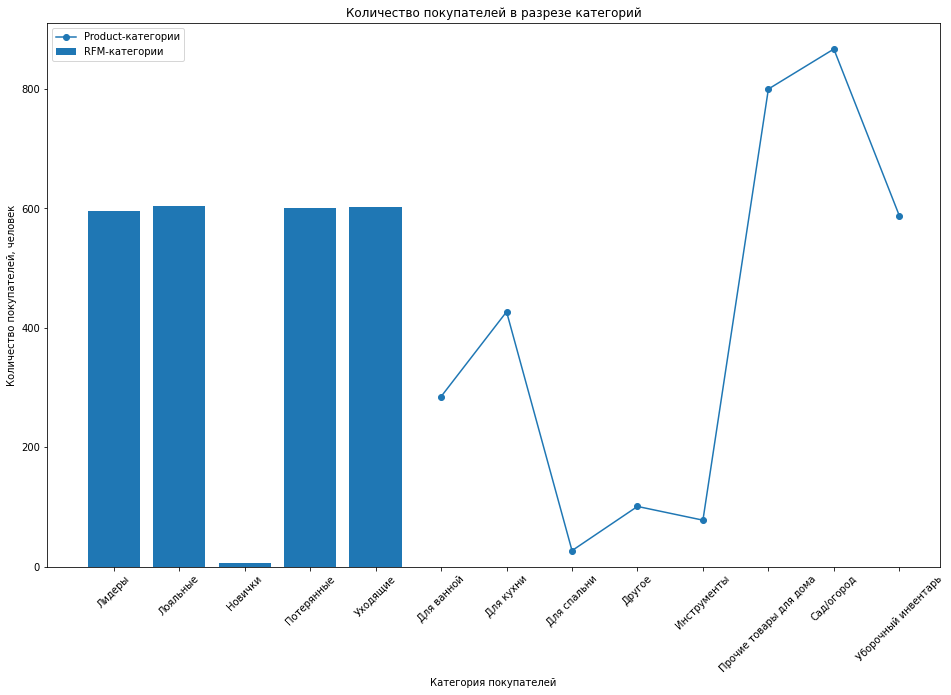

In [45]:
# отразим на графике RFM-категории и Product-категории
Category_count2 = data.groupby('RFMcategory')['customer_id'].nunique()

categoryzer_df = data.groupby('category').agg({'customer_id':'nunique'}).reset_index()

plt.figure(figsize=(16, 10))

plt.bar(Category_count2.index, Category_count2.values, label='RFM-категории')

plt.plot(categoryzer_df['category'], categoryzer_df['customer_id'], marker='o', linestyle='-', label='Product-категории')

plt.xlabel('Категория покупателей')
plt.ylabel('Количество покупателей, человек')
plt.title('Количество покупателей в разрезе категорий')
plt.legend()
plt.xticks(rotation=45)

plt.show()

RFM-категории демонстрируют равномерное распределение доли покупателей между 4 категориями в порядке убывания - уходящие, лояльные, лидеры, потерянные, доля каждой составляет ~25%. Новички составляют всего 0,3%. В Product-категории наибольшее количество покупателей в категории "сад/огород", наименьшее - в категории товаров для спальни.

In [46]:
# формируем сводную таблицу по количеству заказов в разрезе категорий
category_count4 = data.groupby(['RFMcategory', 'category'])['order_id'].count().unstack(level=1)
print('Количество заказов каждой категории:')
category_count4

Количество заказов каждой категории:


category,Для ванной,Для кухни,Для спальни,Другое,Инструменты,Прочие товары для дома,Сад/огород,Уборочный инвентарь
RFMcategory,,,,,,,,
Лидеры,92.0,138.0,10.0,47.0,27.0,275.0,352.0,249.0
Лояльные,83.0,115.0,9.0,21.0,25.0,225.0,281.0,159.0
Новички,1.0,1.0,NaN,NaN,NaN,2.0,1.0,2.0
Потерянные,108.0,200.0,6.0,23.0,22.0,318.0,324.0,157.0
Уходящие,63.0,253.0,4.0,57.0,17.0,195.0,1418.0,152.0


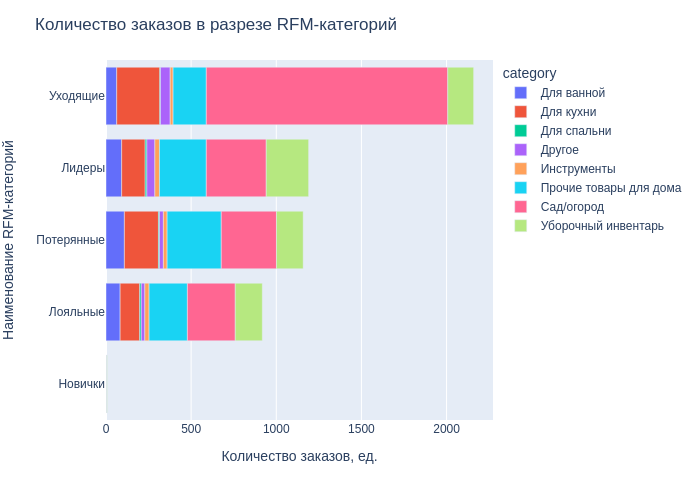

In [47]:
# строим график количества заказов в разрезе RFM-категорий
district_chain_data = data.groupby(['RFMcategory', 'category']).agg({'order_id': 'count'}).reset_index()
district_chain_data = district_chain_data.rename(columns={'order_id': 'count'})

fig = px.bar(district_chain_data,
             x='count',
             y='RFMcategory',
             color='category'
            )
fig.update_layout(title = 'Количество заказов в разрезе RFM-категорий',
                  xaxis_title = 'Количество заказов, ед.',
                  yaxis_title = 'Наименование RFM-категорий',
                  yaxis={'categoryorder': 'total ascending'}
)
fig.show('png')


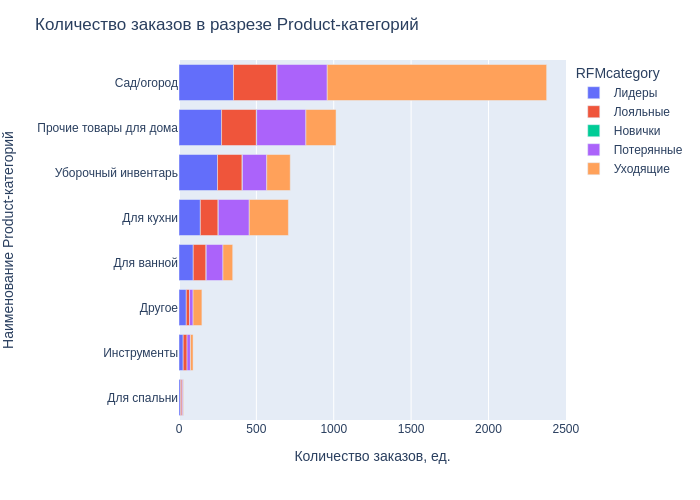

In [48]:
# строим график количества заказов в разрезе Product-категорий
district_chain_data1 = data.groupby(['RFMcategory', 'category']).agg({'order_id': 'count'}).reset_index()
district_chain_data1 = district_chain_data.rename(columns={'order_id': 'count'})

fig = px.bar(district_chain_data1,
             x='count',
             y='category',
             color='RFMcategory'
            )
fig.update_layout(title = 'Количество заказов в разрезе Product-категорий',
                  xaxis_title = 'Количество заказов, ед.',
                  yaxis_title = 'Наименование Product-категорий',
                  yaxis={'categoryorder': 'total ascending'}
)
fig.show('png')

Сводная таблица и графики количества заказов в разрезе RFM-категорий указывает на лидирующую позицию уходящих покупателей, наименьшее количество заказов у категории "новички"; в разрезе Product-категорий больше всего заказов наблюдается в категории "сад/огород", меньше всего - "для спальни". Примечательно, что у уходящих покупателей наибольшее число заказов в категории "сад/огород".

In [49]:
# формируем сводную таблицу по выручке в разрезе категорий
category_count5 = data.groupby(['RFMcategory', 'category'])['revenue'].sum().round(1).unstack(level=1)
print('Сумма выручки в каждой категории:')
category_count5

Сумма выручки в каждой категории:


category,Для ванной,Для кухни,Для спальни,Другое,Инструменты,Прочие товары для дома,Сад/огород,Уборочный инвентарь
RFMcategory,,,,,,,,
Лидеры,68024.0,71522.0,11783.0,14714.0,51188.3,374557.9,84062.0,351561.5
Лояльные,82430.0,70957.0,22477.0,3088.0,52569.0,290433.2,84579.3,216425.2
Новички,15.0,315.0,NaN,NaN,NaN,3898.0,119.0,4116.0
Потерянные,83304.0,157610.0,62490.0,9657.0,33793.0,324499.0,99115.0,241865.0
Уходящие,53958.0,104133.0,32379.0,16482.0,28175.0,323538.0,283406.0,168633.0


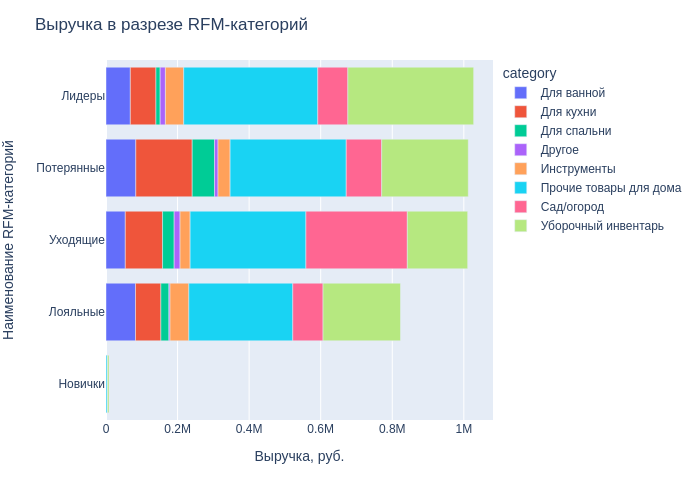

In [50]:
# строим график выручки в разрезе RFM-категорий
district_chain_data = data.groupby(['RFMcategory', 'category']).agg({'revenue': 'sum'}).reset_index()
district_chain_data = district_chain_data.rename(columns={'revenue': 'sum'})

fig = px.bar(district_chain_data,
             x='sum',
             y='RFMcategory',
             color='category'
            )
fig.update_layout(title = 'Выручка в разрезе RFM-категорий',
                  xaxis_title = 'Выручка, руб.',
                  yaxis_title = 'Наименование RFM-категорий',
                  yaxis={'categoryorder': 'total ascending'}
)
fig.show('png')

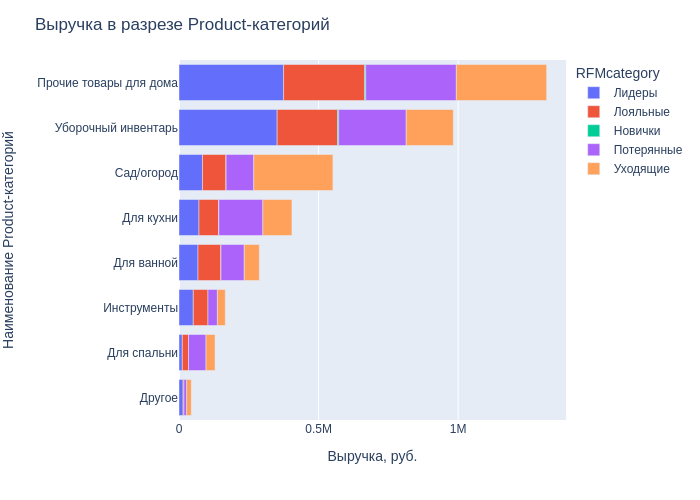

In [51]:
# строим график выручки в разрезе Product-категорий
district_chain_data = data.groupby(['RFMcategory', 'category']).agg({'revenue': 'sum'}).reset_index()
district_chain_data = district_chain_data.rename(columns={'revenue': 'sum'})

fig = px.bar(district_chain_data,
             x='sum',
             y='category',
             color='RFMcategory'
            )
fig.update_layout(title = 'Выручка в разрезе Product-категорий',
                  xaxis_title = 'Выручка, руб.',
                  yaxis_title = 'Наименование Product-категорий',
                  yaxis={'categoryorder': 'total ascending'}
)
fig.show('png')

Сводная таблица и графики выручки в разрезе RFM-категорий отражают идентичные значения показателя между категориями потерянные, лидеры и уходящие, новички ожидаемо находятся на последнем месте. Product-категории прочие товары для дома, уборочный инвентарь, сад/огород являются лидерами по суммарной выручке.

In [52]:
# считаем среднюю стоимость заказа в разрезе RFM-категорий
data.groupby(['RFMcategory'])['revenue'].mean().round(1).sort_values(ascending=False)

RFMcategory
Новички       1209.0
Лояльные       896.5
Потерянные     874.2
Лидеры         863.4
Уходящие       468.1
Name: revenue, dtype: float64

RFMcategory  Лидеры  Лояльные  Новички  Потерянные  Уходящие
month                                                       
2018-10-01      NaN    1190.8      NaN       649.5    1086.1
2018-11-01      NaN    1200.7      NaN       805.4     680.9
2018-12-01   1191.7    1088.2      NaN      1147.4    1023.1
2019-01-01   1027.9       NaN      NaN      1444.4     639.1
2019-02-01    967.7       NaN      NaN       814.9     804.7
2019-03-01   1201.1       NaN      NaN         NaN     465.6
2019-04-01   1074.4    1274.0      NaN         NaN     412.2
2019-05-01    746.1     274.3      NaN         NaN     307.3
2019-06-01   1254.3     109.6      NaN         NaN     663.8
2019-07-01    924.5    1027.8      NaN         NaN     440.6
2019-08-01    810.4     927.3      NaN         NaN       NaN
2019-09-01    991.1     760.2      NaN         NaN       NaN
2019-10-01    359.0     960.6      NaN         NaN       NaN
2019-11-01    585.7     597.5    742.0         NaN       NaN
2019-12-01    817.9     

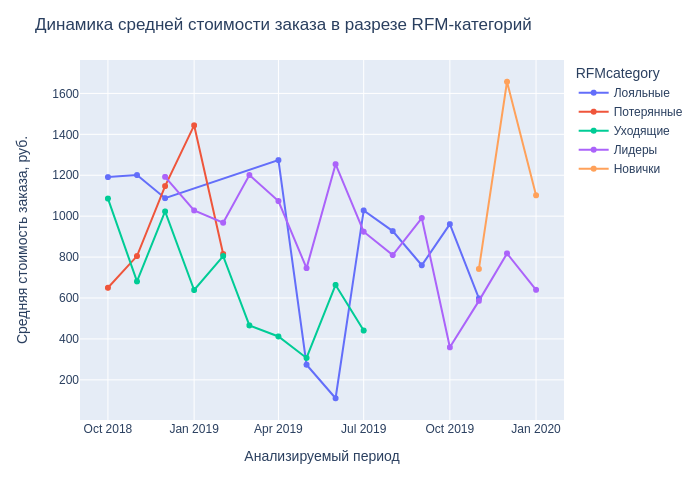

In [53]:
# формируем сводную таблицу и график динамики средней стоимости заказа в разрезе RFM-категорий
data['month'] = data['date'].astype('datetime64[M]')
print(data.groupby(['month', 'RFMcategory'])['revenue'].mean().round(1).unstack(level=1))
# готовим сводную таблицу
df_price_time = data.groupby(['month','RFMcategory'], as_index=False)[['revenue']].mean().round()
# строим линейный график
fig = px.line(df_price_time, # загружаем данные
              x='month', # указываем столбец с данными для оси X
              y='revenue', # указываем столбец с данными для оси Y
              color='RFMcategory', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике
# оформляем график
fig.update_layout(title='Динамика средней стоимости заказа в разрезе RFM-категорий',
                   xaxis_title='Анализируемый период',
                   yaxis_title='Средняя стоимость заказа, руб.')
fig.show('png') # выводим график


Наибольшая средняя стоимость заказа в разрезе RFM-категорий наблюдается в категории "новички" и составляет 1209 рублей, в категориях лояльные, потерянные, лидеры значение показателя сопоставимо. Значительно меньшая средняя стоимость заказа у уходящих покупателей. Динамика средней стоимости заказа в анализируемом периоде в разрезе RFM-категорий свидетельствует о снижении стоимости заказа на конец периода у лидеров и новичков, остальные категории последние покупки совершали: лояльные - ноябрь 2019 г., уходящие - июль 2019 г., потерянные - февраль 2019 г., но все со снижением в заключительном периоде.

category    Для ванной  Для кухни  Для спальни  Другое  Инструменты  \
month                                                                 
2018-10-01        61.0       59.0          3.0     1.0         17.0   
2018-11-01        38.0       83.0          NaN     8.0          7.0   
2018-12-01        27.0       51.0          4.0    15.0          6.0   
2019-01-01        12.0       31.0          3.0     4.0          7.0   
2019-02-01        22.0       36.0          NaN     5.0          3.0   
2019-03-01        23.0       44.0          NaN    23.0          3.0   
2019-04-01        19.0       51.0          2.0    12.0          3.0   
2019-05-01         6.0      119.0          1.0     9.0          4.0   
2019-06-01        17.0       19.0          3.0    15.0          4.0   
2019-07-01        19.0       34.0          1.0     8.0          5.0   
2019-08-01        19.0       23.0          NaN     1.0          3.0   
2019-09-01        20.0       26.0          2.0     4.0          2.0   
2019-1

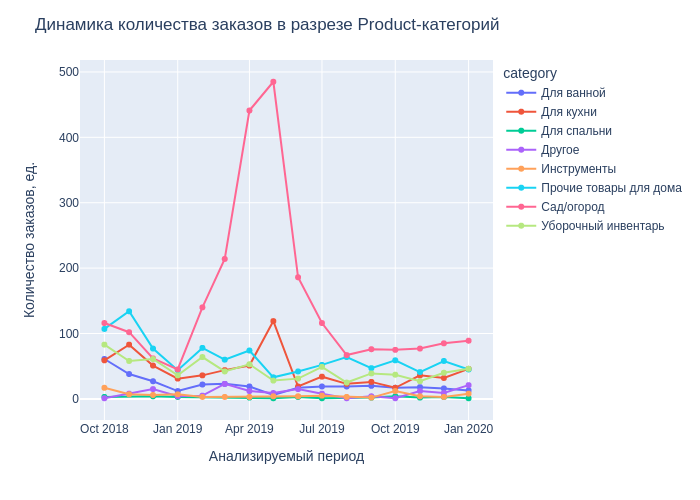

In [54]:
# формируем сводную таблицу и график динамики количества заказов в разрезе Product-категорий
print(data.groupby(['month', 'category'])['order_id'].count().round(1).unstack(level=1))
# готовим сводную таблицу
df_price_time = data.groupby(['month','category'], as_index=False)[['order_id']].count().round()
# строим линейный график
fig = px.line(df_price_time, # загружаем данные
              x='month', # указываем столбец с данными для оси X
              y='order_id', # указываем столбец с данными для оси Y
              color='category', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике
# оформляем график
fig.update_layout(title='Динамика количества заказов в разрезе Product-категорий',
                   xaxis_title='Анализируемый период',
                   yaxis_title='Количество заказов, ед.')
fig.show('png') # выводим график

Динамика количества заказов в разрезе Product-категорий демонстрирует сезонный всплеск товаров в категории товаров для сада/огорода в период с февраля по июль 2019 г. В мае 2019 г. наблюдается повышение продаж в категории товаров для кухни. Остальные товары не имеют выраженных колебаний в динамике количества заказов в разрезе Product-категорий.

#### Вывод
1. В результате сегментации покупателей были выделены 5 RFM-категорий и 8 Product-категорий.
2. По 25% от общего количества покупателей имеют RFM-категории уходящие, лояльные, лидеры, потерянные. Новых покупателей крайне низкое количество - 0,3% от общего числа.
3. Количество покупателей в Product-категории сад/огород превышает остальные категории.
4. Наибольшее количество заказов совершили уходящие покупатели в категории сад/огород.
5. Наибольшая выручка наблюдается в Product-категориях прочих товаров для дома и уборочного инвентаря.
6. Выручка RFM-категорий потерянные, лидеры и уходящие сопоставима.
7. Наибольшую среднюю стоимость заказа в разрезе RFM-категорий демонстрируют новички, в динамике показатель снижался у всех RFM-категорий.
8. На конец анализируемого периода покупки совершали лидеры и новички, остальные категории последние покупки совершали: лояльные - ноябрь 2019 г., уходящие - июль 2019 г., потерянные - февраль 2019 г. В конце отчетного периода возвратные покупки отсутствуют.
9. Product-категория сад/огород демонстрирует сезонные колебания.

### Проверка статистических гипотез

Поскольку RFM-категории формируются на основе 3 показателей недавность, частота и денежное значение были проведены 3 парных статистических теста для проверки следующих гипотез:
- Н0 - между выборками покупателей значимой разницы нет;
- Н1 - между выборками покупателей значимая разница есть;

In [55]:
# статистических тест по средней стоимости заказа
avg_revenue_top = data[data['RFMcategory'] =='Уходящие']['avg_revenue']
avg_revenue_leav = data[data['RFMcategory'] =='Лидеры']['avg_revenue']
results = st.ttest_ind(avg_revenue_top, avg_revenue_leav, equal_var = False) # results = вызов метода для проверки гипотезы

alpha = 0.05 # alpha = значение уровня значимости

print('p-значение:', results.pvalue) # вывод значения p-value на экран 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 3.997922550185309e-22
Отвергаем нулевую гипотезу


In [56]:
# статистических тест по количеству заказов
orders_new = data[data['RFMcategory'] =='Новички']['orders']
orders_lol = data[data['RFMcategory'] =='Лояльные']['orders']
results = st.ttest_ind(orders_new, orders_lol, equal_var = False) # results = вызов метода для проверки гипотезы

alpha = 0.05 # alpha = значение уровня значимости

print('p-значение:', results.pvalue) # вывод значения p-value на экран 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.984799845953899e-24
Отвергаем нулевую гипотезу


/tmp/ipykernel_356/1556009740.py:4: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



In [57]:
# статистических тест по давности совершения покупки
recency_new = data[data['RFMcategory'] =='Новички']['recency']
recency_los = data[data['RFMcategory'] =='Потерянные']['recency']
results = st.ttest_ind(recency_new, recency_los, equal_var = True) # results = вызов метода для проверки гипотезы

alpha = 0.05 # alpha = значение уровня значимости

print('p-значение:', results.pvalue) # вывод значения p-value на экран 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.5421310263420501e-111
Отвергаем нулевую гипотезу


In [58]:
# рассчитаем скорректированный уровень статистической значимости методом Шидака
shidak_alpha = 1 - (1 - 0.05)**(1 / 3)
print('Скорректированный уровень статистической значимости:', shidak_alpha)

Скорректированный уровень статистической значимости: 0.016952427508441503


In [59]:
# статистических тест по средней стоимости заказа
avg_revenue_top = data[data['RFMcategory'] =='Лидеры']['avg_revenue']
avg_revenue_leav = data[data['RFMcategory'] =='Уходящие']['avg_revenue']
results = st.ttest_ind(avg_revenue_top, avg_revenue_leav, equal_var = False) # results = вызов метода для проверки гипотезы

print('p-значение:', results.pvalue) # вывод значения p-value на экран 

if results.pvalue < shidak_alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.997922550185309e-22
Отвергаем нулевую гипотезу


In [60]:
# статистических тест по количеству заказов
orders_new = data[data['RFMcategory'] =='Новички']['orders']
orders_lol = data[data['RFMcategory'] =='Лояльные']['orders']
results = st.ttest_ind(orders_new, orders_lol, equal_var = False) # results = вызов метода для проверки гипотезы

print('p-значение:', results.pvalue) # вывод значения p-value на экран 

if results.pvalue < shidak_alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.984799845953899e-24
Отвергаем нулевую гипотезу


/tmp/ipykernel_356/1773491547.py:4: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



In [61]:
# статистических тест по давности совершения покупки
recency_new = data[data['RFMcategory'] =='Новички']['recency']
recency_los = data[data['RFMcategory'] =='Потерянные']['recency']
results = st.ttest_ind(recency_new, recency_los, equal_var = True) # results = вызов метода для проверки гипотезы

print('p-значение:', results.pvalue) # вывод значения p-value на экран 

if results.pvalue < shidak_alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.5421310263420501e-111
Отвергаем нулевую гипотезу


#### Вывод
Поскольку аудитория исследования разбита более чем на две подгруппы, вероятность получить ошибку первого рода при эксперименте нарастает экспоненциально. С целью контроля групповой вероятности ошибки рассчитан скорректированный уровень статистической значимости методом Шидака и проведены повторные тесты с учетом скорректированного уровеня статистической значимости.

В результате статистических тестов гипотеза Н0 - между выборками покупателей значимой разницы нет - по средней стоимости заказа, по количеству заказов, по давности совершения покупки - была отвергнута. Значимые различия между RFM-категориями есть.

### Рекомендации

1. Активное привлечение новых покупателей, стимулирование повторных покупок.
2. Поощрение лидеров, персонализированные предложения.
3. Работа с уходящими потребителями, у которых много покупок сезонного характера, ознакомление с ассортиментом, рекомендации.
4. Включение лояльных покупателей в обратную связь, скидки, промокоды.
5. Рассылка напоминающей информации потерянным покупателям.
6. Уменьшение доли сезонных товаров, диверсификация товаров.

Презентация: https://disk.yandex.ru/i/3A6sqEAD7PWa2w

Дашборд: https://public.tableau.com/views/E-com_16959232661220/sheet3?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

В дашборде под количеством покупок понимается количество заказов, настроен action по количеству и периоду покупок.